In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller

In [7]:
load = pd.read_csv('../../Data/load.csv')
prices = pd.read_csv('../../Data/prices.csv')
res_gen = pd.read_csv('../../Data/res_gen.csv')
residual_gen = pd.read_csv('../../Data/residual_generation.csv')

load['date'] = pd.to_datetime(load['date'])
prices['date'] = pd.to_datetime(prices['date'])
res_gen['date'] = pd.to_datetime(res_gen['date'])
residual_gen['date'] = pd.to_datetime(residual_gen['date'])

# exclude the France from every dataset
load = load.drop(columns=['load_FRA'])
res_gen = res_gen.drop(columns=['windonshore_forecastFRA', 'solar_forecastFRA'])
residual_gen = residual_gen.drop(columns=['residual_generationFRA'])
prices = prices.drop(columns=['price_FRA'])

In [3]:
# Merge all datasets to find common dates
all_merged = pd.merge(load[['date']], prices[['date']], on='date', how='inner')
all_merged = pd.merge(all_merged, res_gen[['date']], on='date', how='inner')
all_merged = pd.merge(all_merged, residual_gen[['date']], on='date', how='inner')

# Extract the common dates
common_dates = all_merged['date'].unique()

load = load[load['date'].isin(common_dates)]
prices = prices[prices['date'].isin(common_dates)]
res_gen = res_gen[res_gen['date'].isin(common_dates)]
residual_gen = residual_gen[residual_gen['date'].isin(common_dates)]

In [8]:
# Check the number of rows in each dataset should be the same
print(f"Rows in load: {load.shape[0]}")
print(f"Rows in prices: {prices.shape[0]}")
print(f"Rows in res_gen: {res_gen.shape[0]}")
print(f"Rows in residual_gen: {residual_gen.shape[0]}")

Rows in load: 43819
Rows in prices: 43818
Rows in res_gen: 43320
Rows in residual_gen: 42960


In [10]:
#print how many missing values are in each dataset
print(f"Missing values in load: {load.isnull().sum().sum()}")
print(f"Missing values in prices: {prices.isnull().sum().sum()}")
print(f"Missing values in res_gen: {res_gen.isnull().sum().sum()}")
print(f"Missing values in residual_gen: {residual_gen.isnull().sum().sum()}")


Missing values in load: 0
Missing values in prices: 4
Missing values in res_gen: 0
Missing values in residual_gen: 0


## LOAD

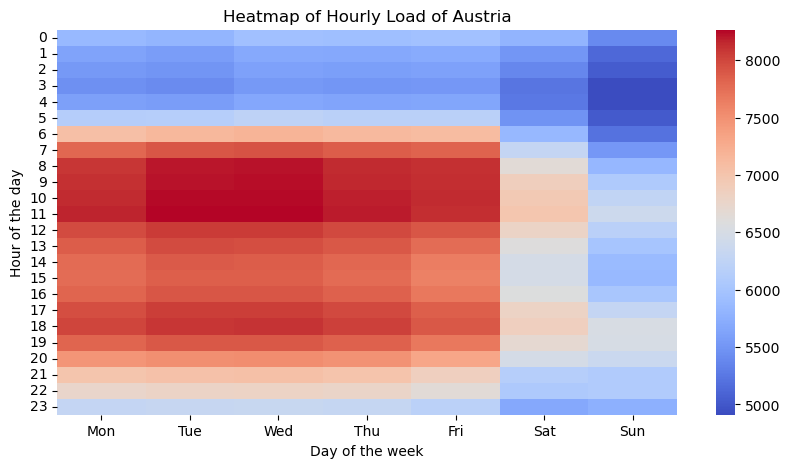

In [134]:
# Heatmap of Hourly Load of all:
load['hour'] = load['date'].dt.hour
load['day'] = load['date'].dt.dayofweek
load['month'] = load['date'].dt.month
load['year'] = load['date'].dt.year

load_pivot1 = load.pivot_table(index='hour', columns='day', values='load_AT', aggfunc='mean')

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(load_pivot1, cmap='coolwarm', ax=ax)

ax.set_title('Heatmap of Hourly Load of Austria')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Hour of the day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


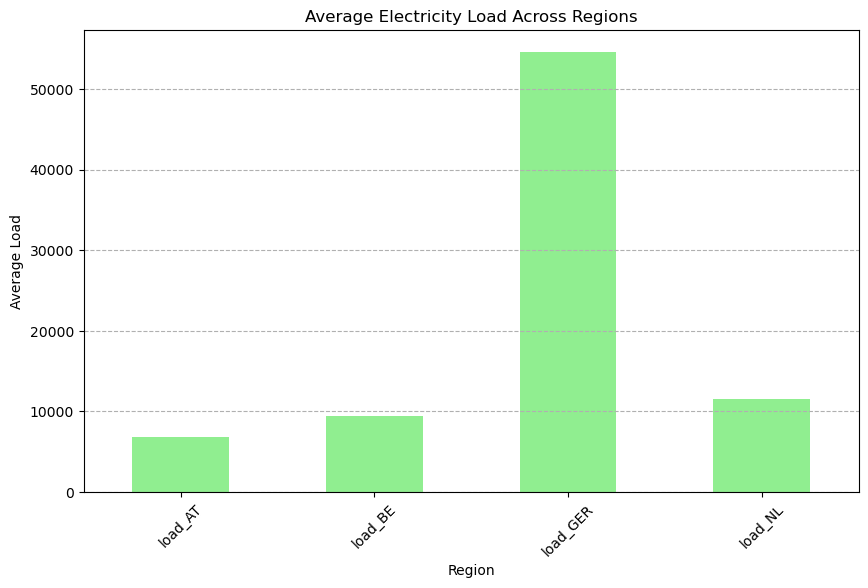

load_AT      6865.405163
load_BE      9426.877709
load_GER    54581.621764
load_NL     11472.068142
dtype: float64


In [135]:
average_load = load[['load_AT', 'load_BE', 'load_GER', 'load_NL']].mean()
average_load_plot = average_load.plot(kind='bar', figsize=(10, 6), color='lightgreen')

plt.title('Average Electricity Load Across Regions')
plt.xlabel('Region')
plt.ylabel('Average Load')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

print(average_load )

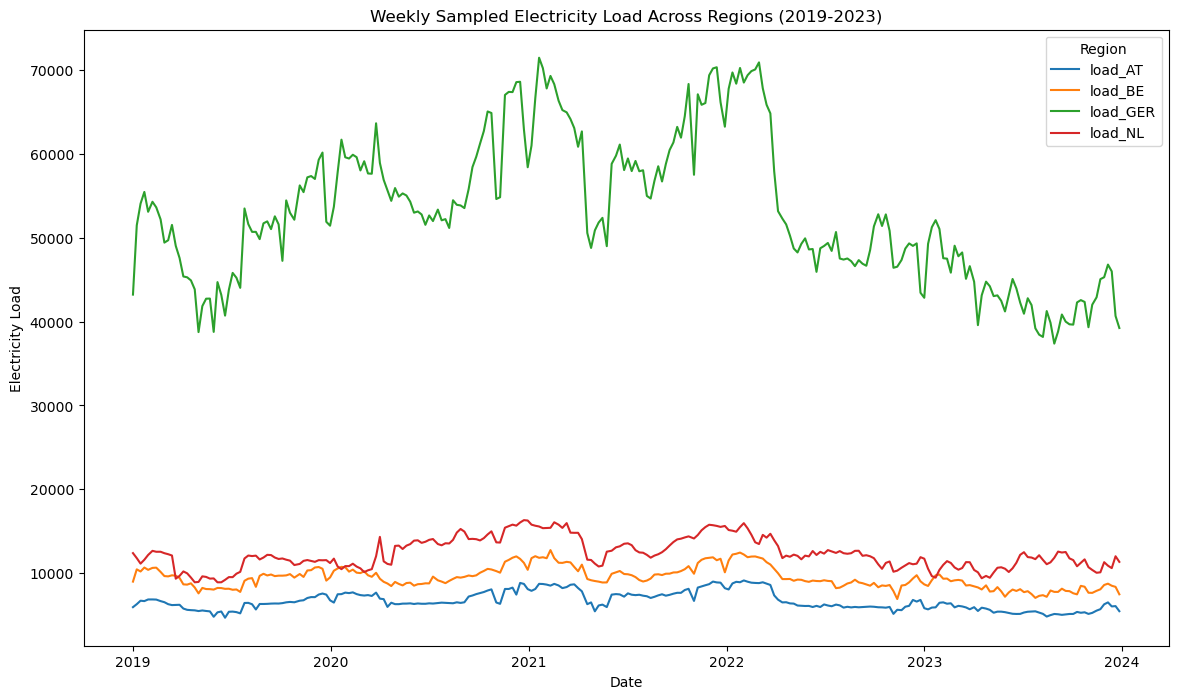

In [136]:
plt.figure(figsize=(14, 8))

for column in ['load_AT', 'load_BE', 'load_GER', 'load_NL']:
    # We'll plot a sample of the data to keep the plot legible and focused
    sampled_data = load.loc[::24*7, ['date', column]]  # Weekly sampling for clarity
    sns.lineplot(x='date', y=column, data=sampled_data, label=column)

plt.title('Weekly Sampled Electricity Load Across Regions (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.legend(title='Region')

plt.show()

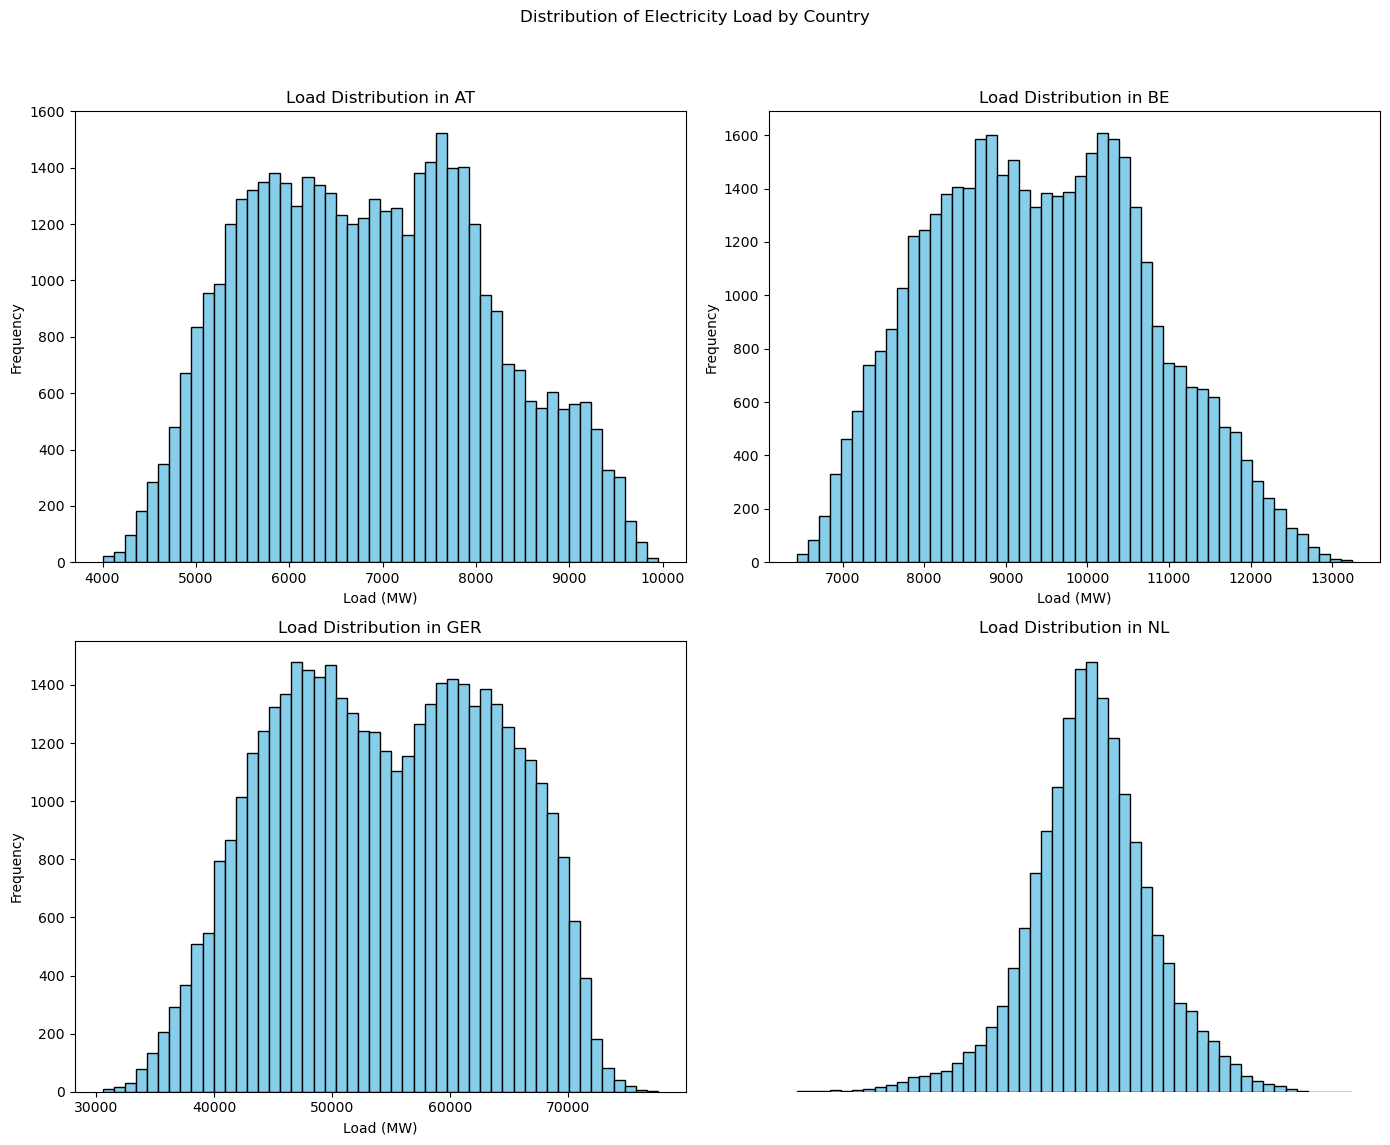

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
fig.suptitle('Distribution of Electricity Load by Country')

axes = axes.flatten()

for i, country_code in enumerate(['AT', 'BE','GER', 'NL']):
    axes[i].hist(load[f'load_{country_code}'], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Load Distribution in {country_code}')
    axes[i].set_xlabel('Load (MW)')
    axes[i].set_ylabel('Frequency')

axes[-1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

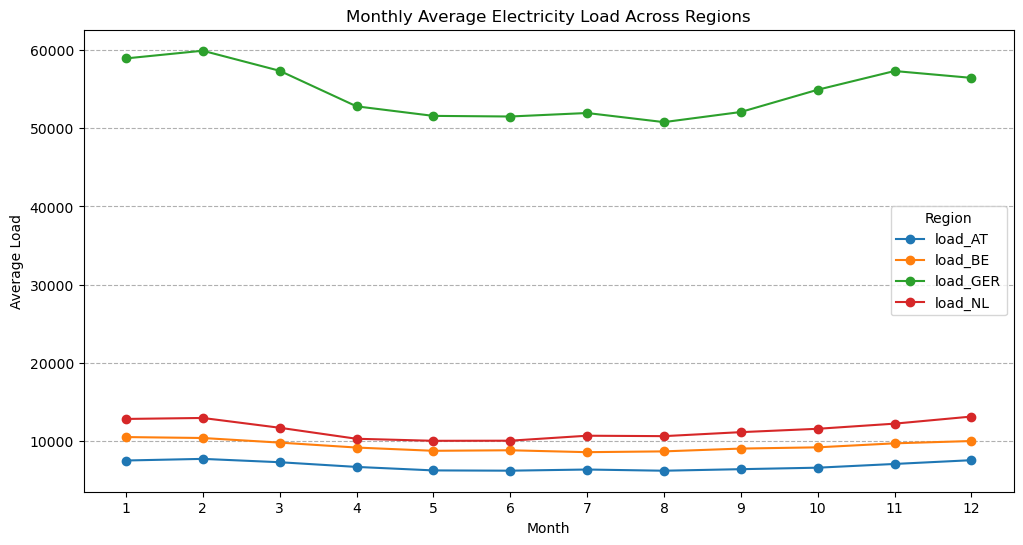

In [138]:
# Plotting the monthly average load for each region to identify seasonal patterns
load['month'] = load['date'].dt.month
monthly_avg_load = load.groupby('month')[['load_AT', 'load_BE', 'load_GER', 'load_NL']].mean()

plt.figure(figsize=(12, 6))
for column in monthly_avg_load.columns:
    plt.plot(monthly_avg_load.index, monthly_avg_load[column], marker='o', label=column)

plt.title('Monthly Average Electricity Load Across Regions')
plt.xlabel('Month')
plt.ylabel('Average Load')
plt.xticks(monthly_avg_load.index)
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--')


## PRICES

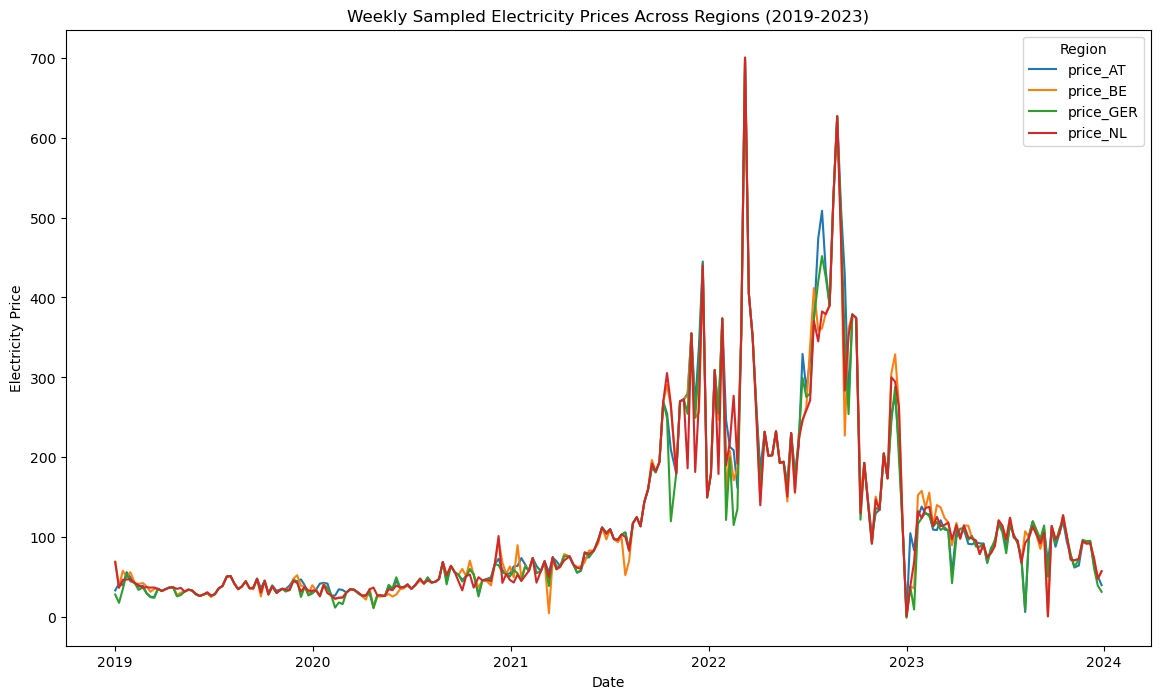

In [169]:
plt.figure(figsize=(14, 8))

for column in ['price_AT', 'price_BE', 'price_GER', 'price_NL']:
    # We'll plot a sample of the data to keep the plot legible and focused
    sampled_data = prices.loc[::24*7, ['date', column]]  # Weekly sampling for clarity
    sns.lineplot(x='date', y=column, data=sampled_data, label=column)

plt.title('Weekly Sampled Electricity Prices Across Regions (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.legend(title='Region')

plt.show()

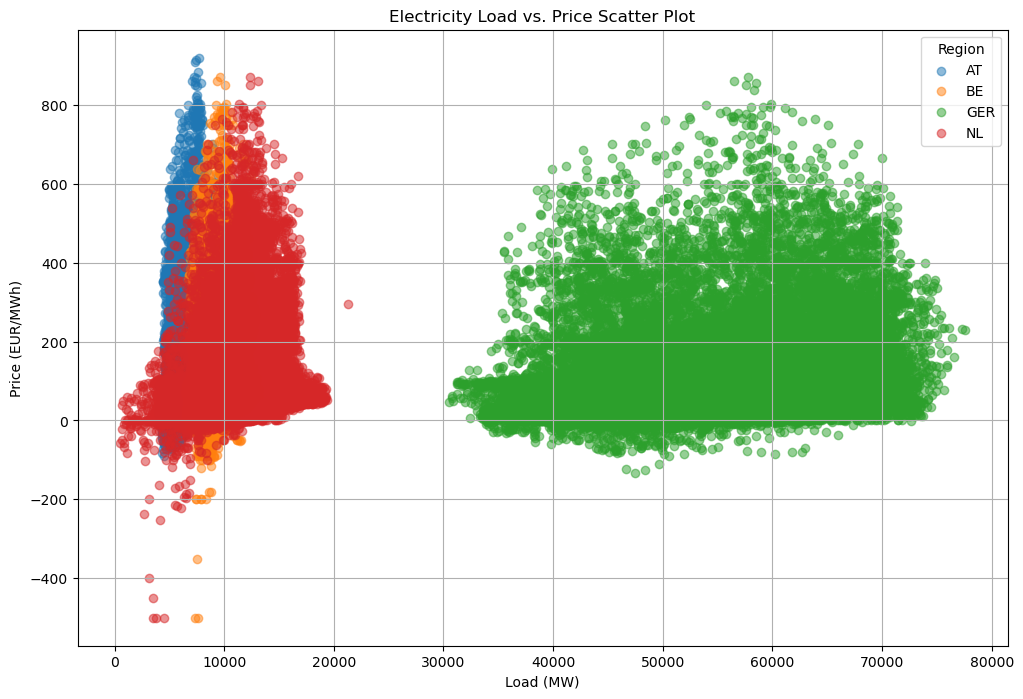

In [140]:
# Price vs. Load Scatter Plot
load_prices = pd.merge(load, prices, on='date', suffixes=('_load', '_price'))

plt.figure(figsize=(12, 8))
for region in ['AT', 'BE', 'GER', 'NL']:
    plt.scatter(load_prices[f'load_{region}'], load_prices[f'price_{region}'], alpha=0.5, label=region)

plt.title('Electricity Load vs. Price Scatter Plot')
plt.xlabel('Load (MW)')
plt.ylabel('Price (EUR/MWh)')
plt.legend(title='Region')
plt.grid(True)

plt.show()


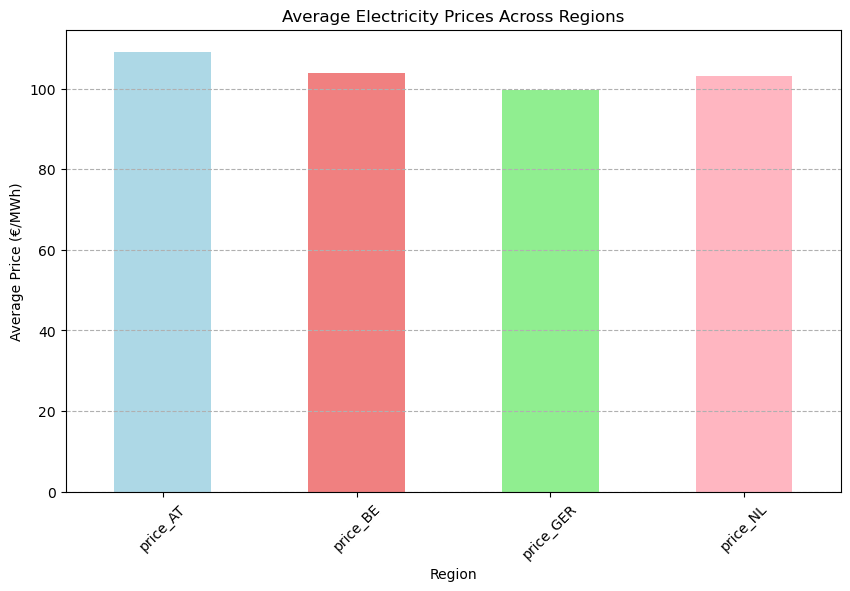

price_AT     109.175181
price_BE     103.917227
price_GER     99.601475
price_NL     103.237706
dtype: float64


In [141]:
average_prices = prices[['price_AT', 'price_BE', 'price_GER', 'price_NL']].mean(skipna=True)
average_prices_plot = average_prices.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightsalmon'])

plt.title('Average Electricity Prices Across Regions')
plt.xlabel('Region')
plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

print(average_prices)

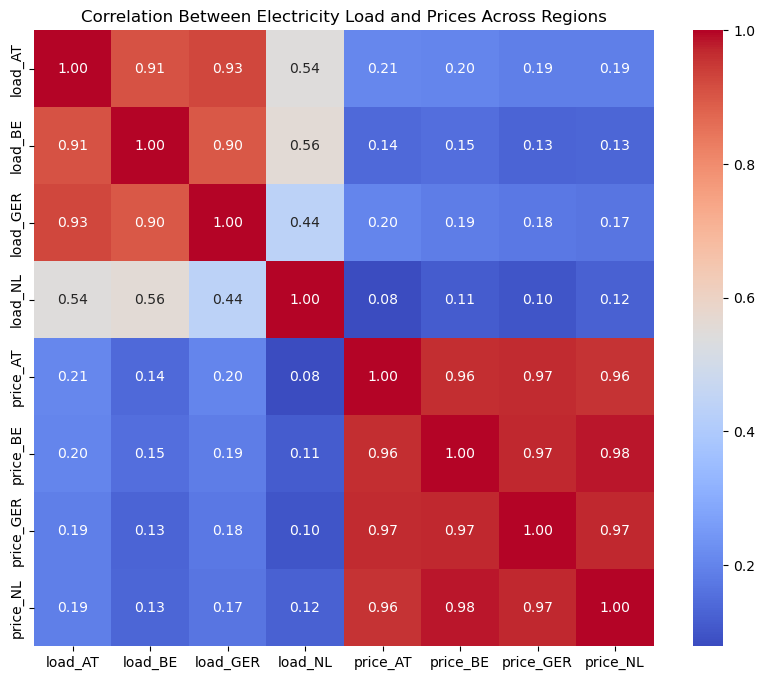

In [142]:
# Correlation Heatmap Between Load and Price
load_prices_corr = load_prices[['load_AT', 'load_BE',  'load_GER', 'load_NL',
                                'price_AT', 'price_BE', 'price_GER', 'price_NL']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(load_prices_corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Between Electricity Load and Prices Across Regions')
plt.show()


## RES_GEN

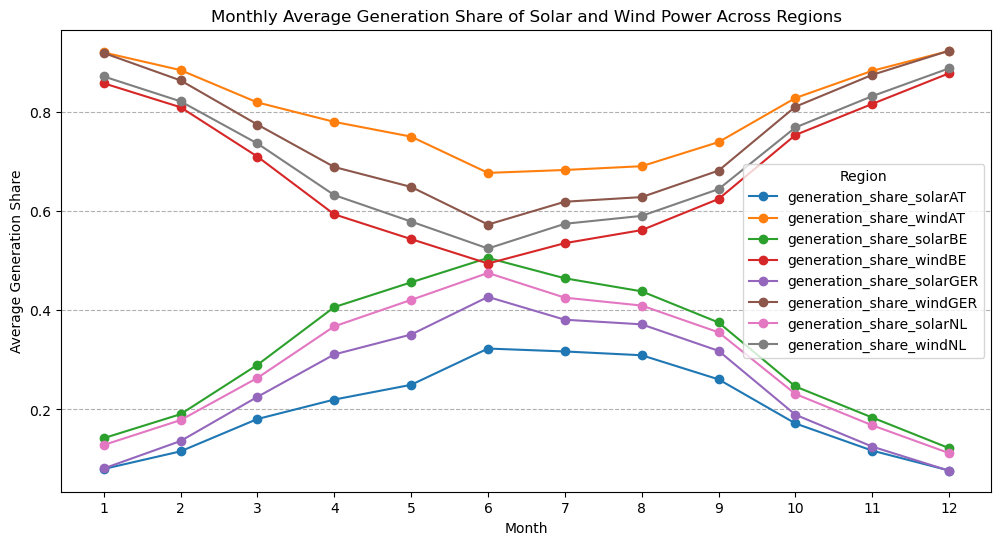

In [143]:
# Renewable vs. Total Generation: For each region
res_gen['year'] = res_gen['date'].dt.year
res_gen['month'] = res_gen['date'].dt.month
res_gen['generation_totalAT'] = res_gen['solar_forecastAT'] + res_gen['windonshore_forecastAT'] 
res_gen['generation_totalBE'] = res_gen['solar_forecastBE'] + res_gen['windonshore_forecastBE']
res_gen['generation_totalGER'] = res_gen['solar_forecastGER'] + res_gen['windonshore_forecastGER']
res_gen['generation_totalNL'] = res_gen['solar_forecastNL'] + res_gen['windonshore_forecastNL']

res_gen['generation_share_solarAT'] = res_gen['solar_forecastAT'] / res_gen['generation_totalAT']
res_gen['generation_share_solarBE'] = res_gen['solar_forecastBE'] / res_gen['generation_totalBE']
res_gen['generation_share_solarGER'] = res_gen['solar_forecastGER'] / res_gen['generation_totalGER']
res_gen['generation_share_solarNL'] = res_gen['solar_forecastNL'] / res_gen['generation_totalNL']

res_gen['generation_share_windAT'] = res_gen['windonshore_forecastAT'] / res_gen['generation_totalAT']
res_gen['generation_share_windBE'] = res_gen['windonshore_forecastBE'] / res_gen['generation_totalBE']
res_gen['generation_share_windGER'] = res_gen['windonshore_forecastGER'] / res_gen['generation_totalGER']
res_gen['generation_share_windNL'] = res_gen['windonshore_forecastNL'] / res_gen['generation_totalNL']

# Plotting the monthly average generation share of solar and wind power for each region
monthly_avg_generation_share = res_gen.groupby('month')[['generation_share_solarAT', 'generation_share_windAT',
                                                         'generation_share_solarBE', 'generation_share_windBE',
                                                         'generation_share_solarGER', 'generation_share_windGER',
                                                         'generation_share_solarNL', 'generation_share_windNL']].mean()

plt.figure(figsize=(12, 6))
for column in monthly_avg_generation_share.columns:
    plt.plot(monthly_avg_generation_share.index, monthly_avg_generation_share[column], marker='o', label=column)

plt.title('Monthly Average Generation Share of Solar and Wind Power Across Regions')
plt.xlabel('Month')
plt.ylabel('Average Generation Share')
plt.xticks(monthly_avg_generation_share.index)
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--')

plt.show()

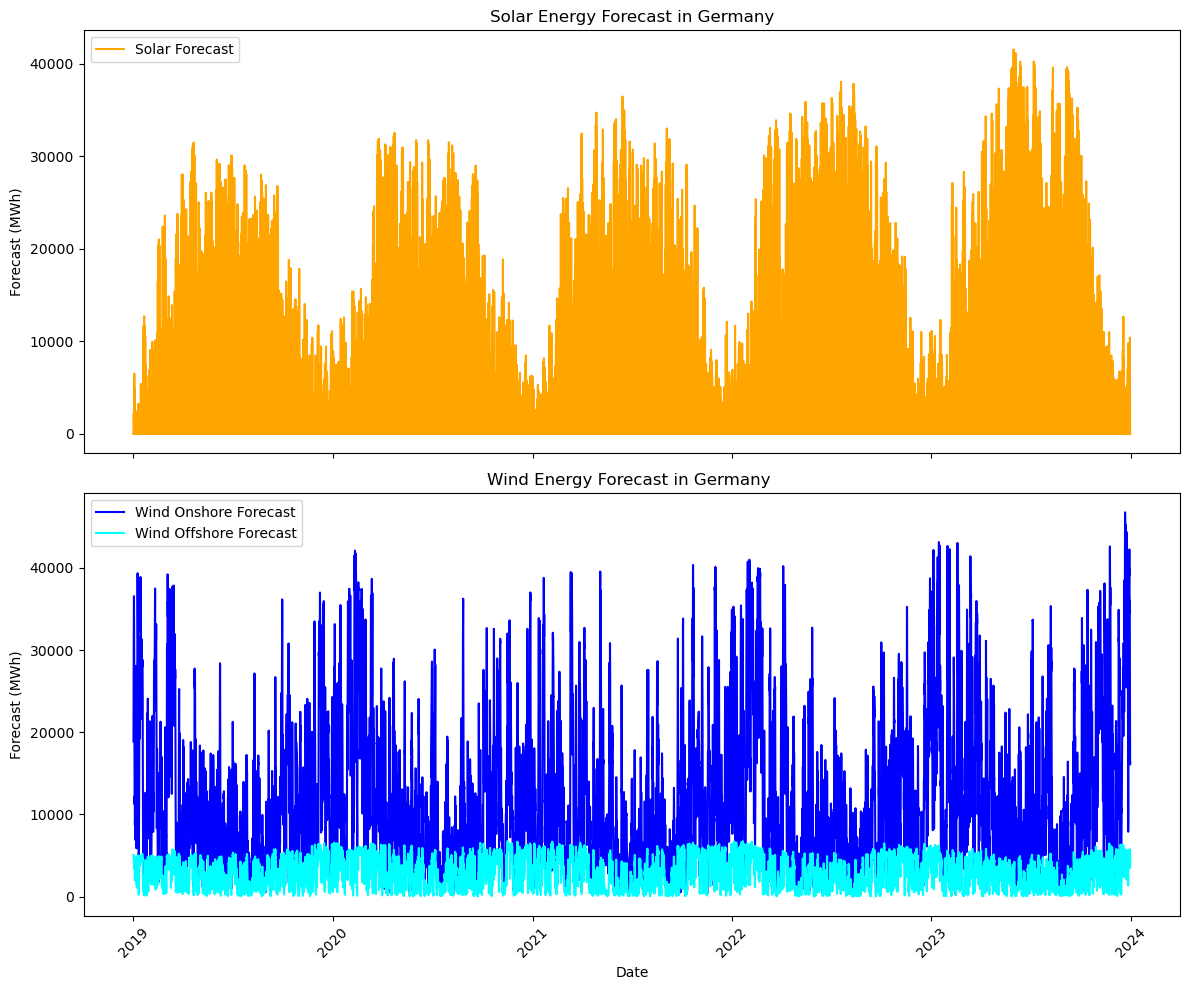

In [144]:
data_subset = res_gen[(res_gen['date'] >= '2019-01-01') & (res_gen['date'] < '2023-12-31')]

# Time series plot for solar and wind energy forecasts in Germany as an example
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Solar forecast for Germany
ax[0].plot(data_subset['date'], data_subset['solar_forecastGER'], label='Solar Forecast', color='orange')
ax[0].set_title('Solar Energy Forecast in Germany')
ax[0].set_ylabel('Forecast (MWh)')
ax[0].legend()

# Wind forecast for Germany (combining onshore and offshore)
ax[1].plot(data_subset['date'], data_subset['windonshore_forecastGER'], label='Wind Onshore Forecast', color='blue')
ax[1].plot(data_subset['date'], data_subset['windoffshore_forecastGER'], label='Wind Offshore Forecast', color='cyan')
ax[1].set_title('Wind Energy Forecast in Germany ')
ax[1].set_ylabel('Forecast (MWh)')
ax[1].set_xlabel('Date')
ax[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## RESIDUAL_GENERATION

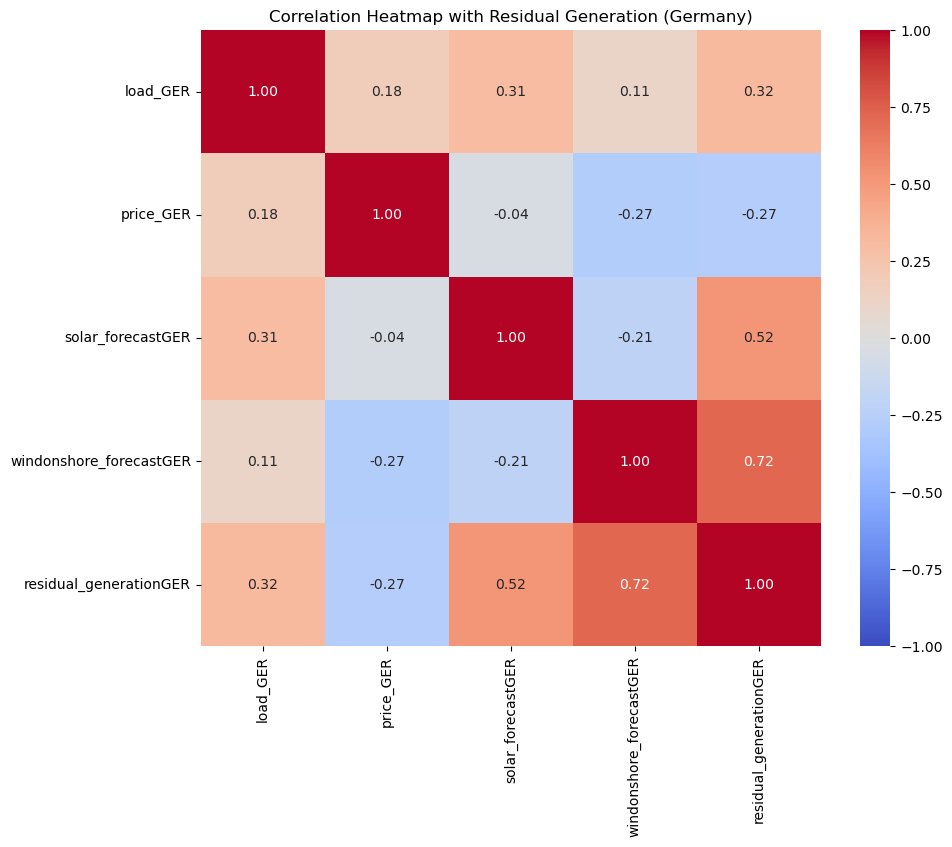

In [145]:
merged_data = pd.merge(load, prices, on='date', how='inner')
comprehensive_data = pd.merge(merged_data, res_gen, on='date', how='inner')

comprehensive_data_with_residual = pd.merge(comprehensive_data, residual_gen, on='date', how='inner')

variables_of_interest_with_residual = [
    'load_GER', 
    'price_GER', 
    'solar_forecastGER', 
    'windonshore_forecastGER',
    'residual_generationGER'
]

# Subset the data to only include the variables of interest
subset_data_with_residual = comprehensive_data_with_residual[variables_of_interest_with_residual]

# Calculating the correlation matrix for the selected subset with 'residual_generationGER'
correlation_matrix_with_residual = subset_data_with_residual.corr()

# Plotting the correlation heatmap with 'residual_generationGER'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_residual, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Residual Generation (Germany)')
plt.show()

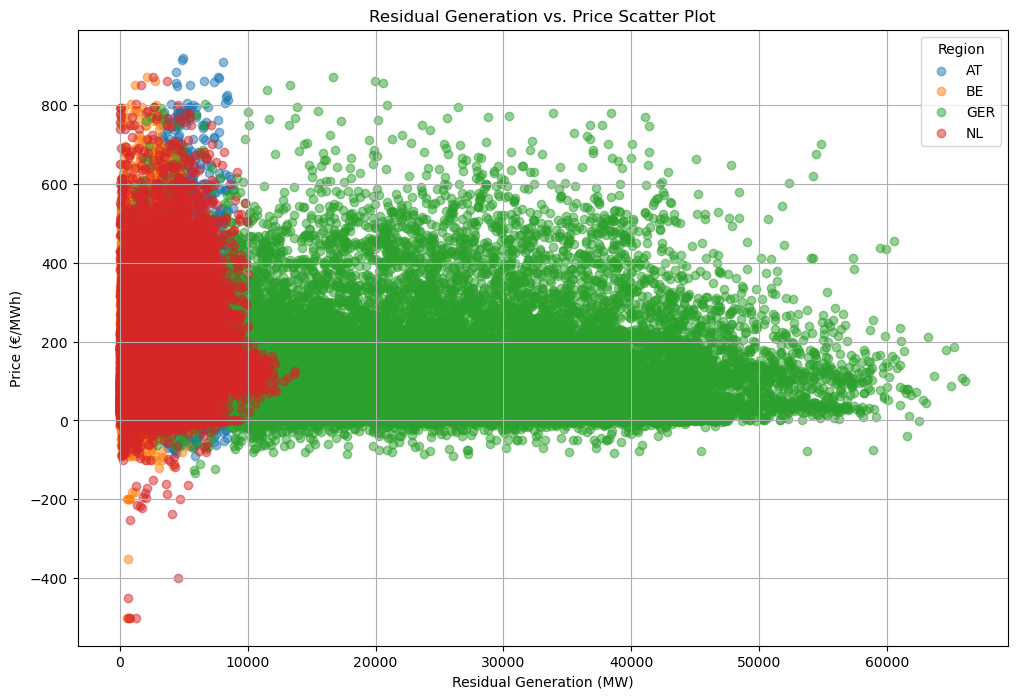

In [146]:
plt.figure(figsize=(12, 8))
for region in ['AT', 'BE', 'GER', 'NL']:
    merged = pd.merge(residual_gen[[f'residual_generation{region}']], prices[[f'price_{region}']], left_index=True, right_index=True, how='inner')
    plt.scatter(merged[f'residual_generation{region}'], merged[f'price_{region}'], alpha=0.5, label=region)


plt.title('Residual Generation vs. Price Scatter Plot')
plt.xlabel('Residual Generation (MW)')
plt.ylabel('Price (€/MWh)')
plt.legend(title='Region')
plt.grid(True)

plt.show()

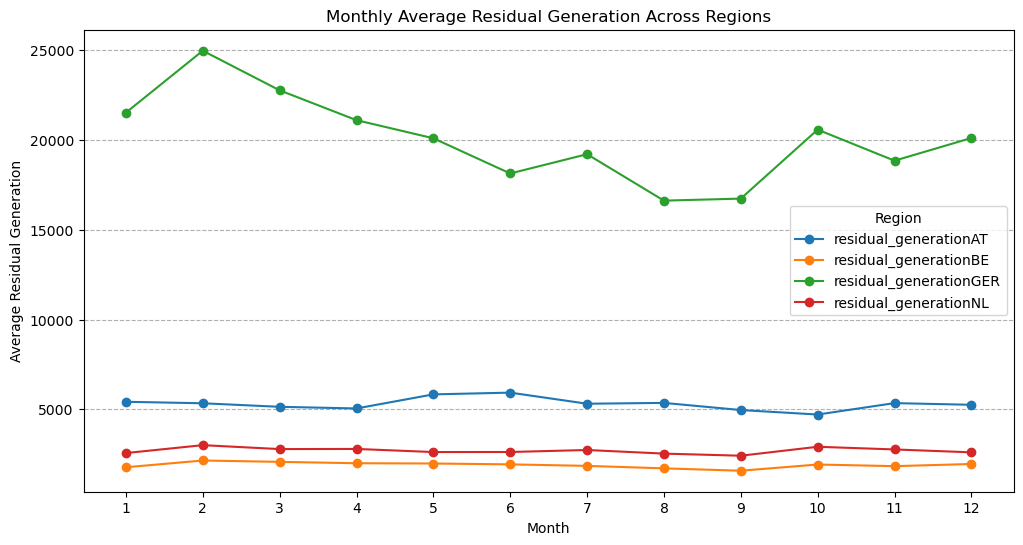

In [147]:

# Plotting the monthly average residual generation for each region to identify seasonal patterns
residual_gen['month'] = residual_gen['date'].dt.month
monthly_avg_residual_gen = residual_gen.groupby('month')[['residual_generationAT', 'residual_generationBE', 'residual_generationGER', 'residual_generationNL']].mean()

plt.figure(figsize=(12, 6))
for column in monthly_avg_residual_gen.columns:
    plt.plot(monthly_avg_residual_gen.index, monthly_avg_residual_gen[column], marker='o', label=column)

plt.title('Monthly Average Residual Generation Across Regions')
plt.xlabel('Month')
plt.ylabel('Average Residual Generation')
plt.xticks(monthly_avg_residual_gen.index)
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--')

plt.show()



In [195]:

# def adf_test(timeseries):
#     # Perform Dickey-Fuller test:
#     dftest = adfuller(timeseries, autolag='AIC')
#     # Extract only required results
#     dfoutput = {
#         'Test Statistic': dftest[0],
#         'p-value': dftest[1],
#         'Critical Values': dftest[4]  # This is a dictionary of critical values
#     }
#     return dfoutput

# adf_results = {}

# regions = ['load_AT', 'load_BE', 'load_GER', 'load_NL']
# for region in regions:
#     adf_results[region] = adf_test(load[region])

# print(adf_results)

def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    # Extract only required results and format them
    dfoutput = {
        'Test Statistic': dftest[0],
        'p-value': dftest[1],
        'Critical Value 1%': dftest[4]['1%'],
        'Critical Value 5%': dftest[4]['5%'],
        'Critical Value 10%': dftest[4]['10%']
    }
    return dfoutput

# Create an empty DataFrame to store results
adf_results_load = pd.DataFrame()

# Applying the test to each region and storing the results
regions = ['load_AT', 'load_BE', 'load_GER', 'load_NL']
for region in regions:
    result = adf_test(load[region])
    temp_load = pd.DataFrame([{
        'Region': region,
        'Test Statistic': result['Test Statistic'],
        'p-value': result['p-value'],
        'Critical Value 1%': result['Critical Value 1%'],
        'Critical Value 5%': result['Critical Value 5%'],
        'Critical Value 10%': result['Critical Value 10%']
    }])
    adf_results_load = pd.concat([adf_results_load, temp_load], ignore_index=True)

# Display the DataFrame
print(adf_results_load)

     Region  Test Statistic       p-value  Critical Value 1%  \
0   load_AT      -15.062010  8.976215e-28          -3.430502   
1   load_BE      -13.950108  4.718937e-26          -3.430502   
2  load_GER      -18.611022  2.065151e-30          -3.430502   
3   load_NL      -11.728088  1.362280e-21          -3.430502   

   Critical Value 5%  Critical Value 10%  
0          -2.861607           -2.566806  
1          -2.861607           -2.566806  
2          -2.861607           -2.566806  
3          -2.861607           -2.566806  


In [196]:
# Create an empty DataFrame to store results
adf_results_price = pd.DataFrame()

# Applying the test to each region and storing the results
regions = ['price_AT', 'price_BE', 'price_GER', 'price_NL']
for region in regions:
    result = adf_test(prices[region])
    temp_price = pd.DataFrame([{
        'Region': region,
        'Test Statistic': result['Test Statistic'],
        'p-value': result['p-value'],
        'Critical Value 1%': result['Critical Value 1%'],
        'Critical Value 5%': result['Critical Value 5%'],
        'Critical Value 10%': result['Critical Value 10%']
    }])
    adf_results_price = pd.concat([adf_results_price, temp_price], ignore_index=True)

# Display the DataFrame
print(adf_results_price)

      Region  Test Statistic       p-value  Critical Value 1%  \
0   price_AT       -5.595002  1.303085e-06          -3.430502   
1   price_BE       -6.104525  9.656132e-08          -3.430502   
2  price_GER       -7.346551  1.031996e-10          -3.430502   
3   price_NL       -6.094939  1.015385e-07          -3.430502   

   Critical Value 5%  Critical Value 10%  
0          -2.861607           -2.566806  
1          -2.861607           -2.566806  
2          -2.861607           -2.566806  
3          -2.861607           -2.566806  


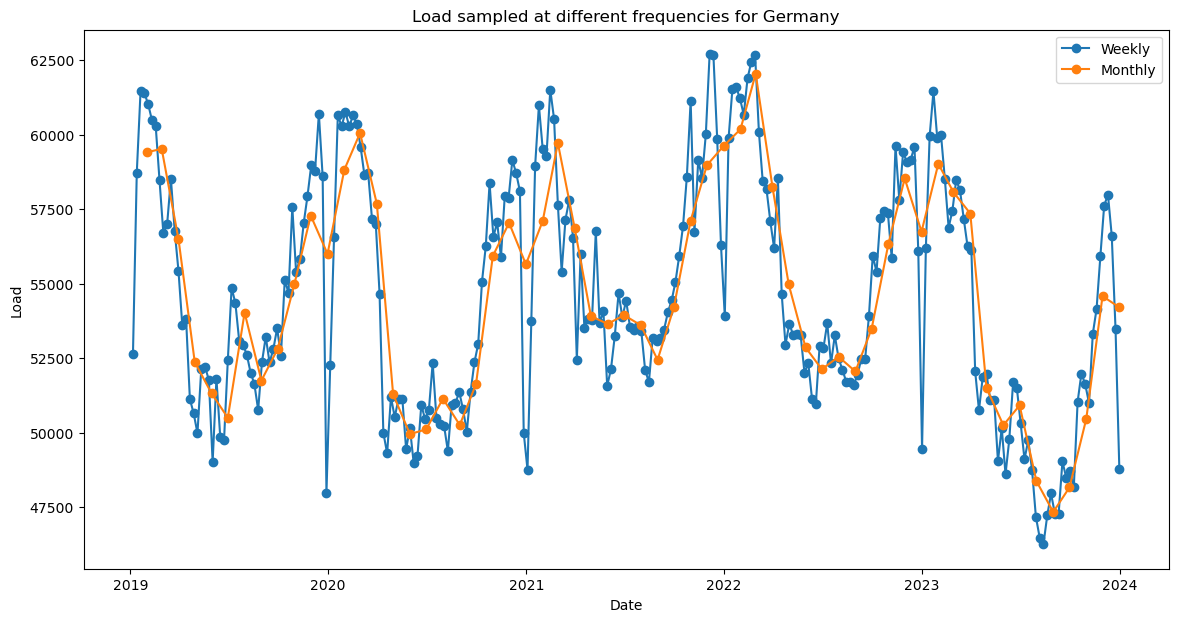

In [12]:
load.set_index('date', inplace=True)

load_weekly = load['load_GER'].resample('W').mean()
load_monthly = load['load_GER'].resample('M').mean()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(load_weekly.index, load_weekly, label='Weekly',marker='o')
plt.plot(load_monthly.index, load_monthly, label='Monthly',marker='o')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Load sampled at different frequencies for Germany')
plt.legend()
plt.show()

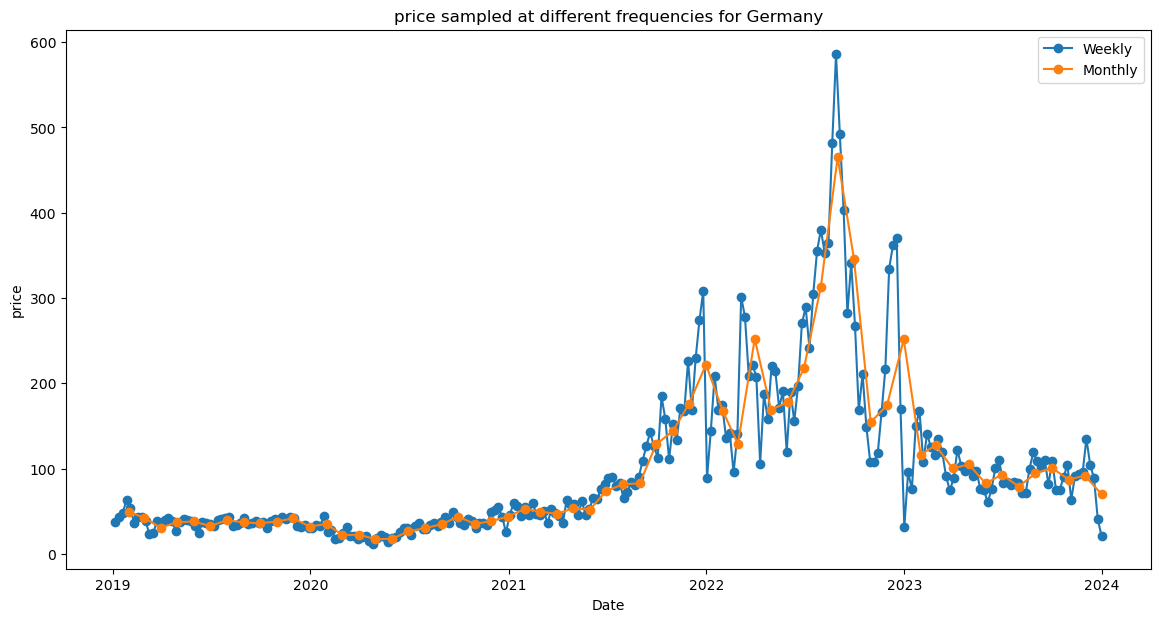

In [17]:
prices.set_index('date', inplace=True)

price_weekly = prices['price_GER'].resample('W').mean()
price_monthly = prices['price_GER'].resample('M').mean()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(price_weekly.index, price_weekly, label='Weekly',marker='o')
plt.plot(price_monthly.index, price_monthly, label='Monthly',marker='o')
plt.xlabel('Date')
plt.ylabel('price')
plt.title('price sampled at different frequencies for Germany')
plt.legend()
plt.show()

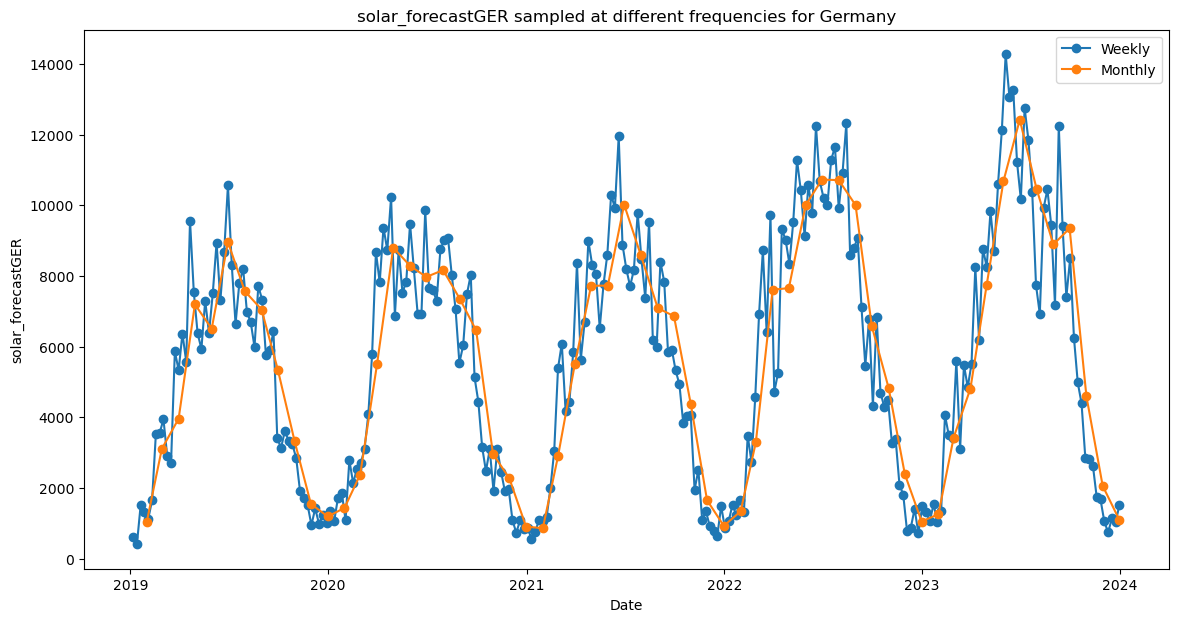

In [18]:
# seasonality of res_gen
res_gen.set_index('date', inplace=True)

res_gen_weekly = res_gen['solar_forecastGER'].resample('W').mean()
res_gen_monthly = res_gen['solar_forecastGER'].resample('M').mean()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(res_gen_weekly.index, res_gen_weekly, label='Weekly',marker='o')
plt.plot(res_gen_monthly.index, res_gen_monthly, label='Monthly',marker='o')
plt.xlabel('Date')
plt.ylabel('solar_forecastGER')
plt.title('solar_forecastGER sampled at different frequencies for Germany')
plt.legend()
plt.show()



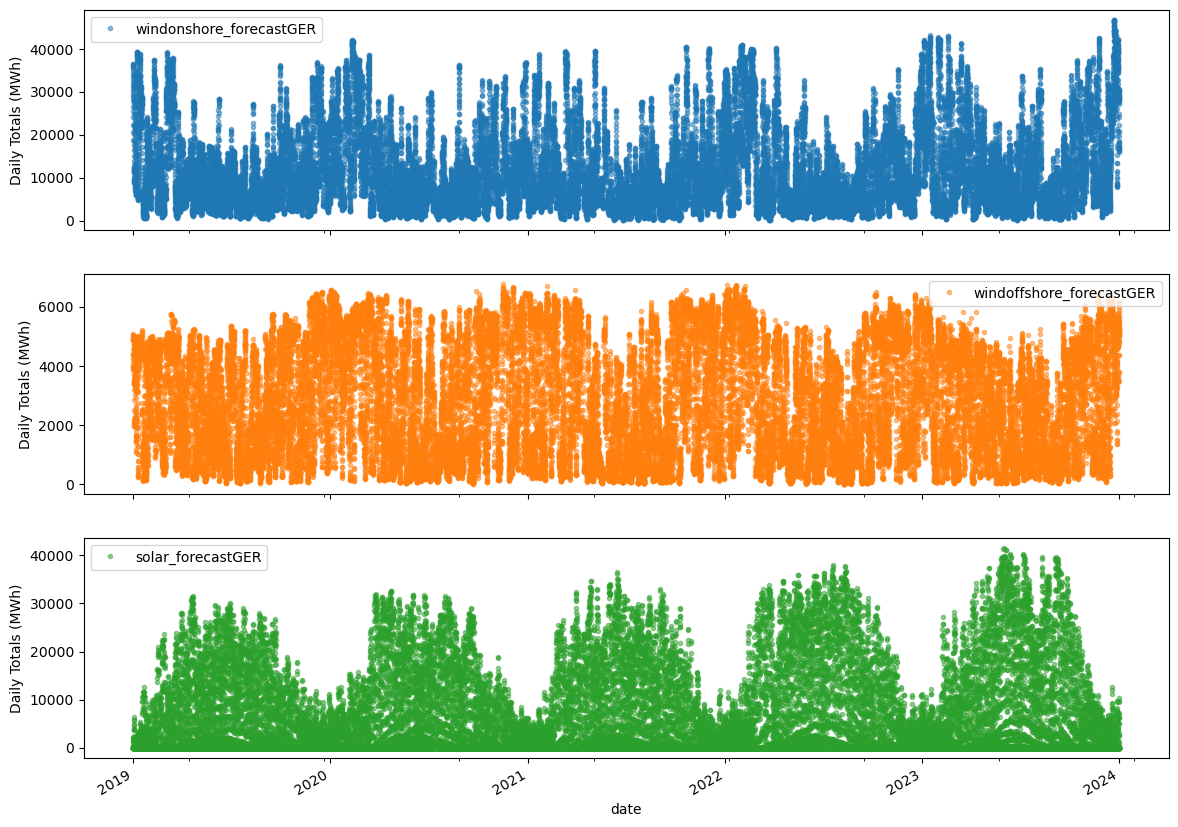

In [20]:
cols_plot = ['windonshore_forecastGER', 'windoffshore_forecastGER', 'solar_forecastGER']
axes = res_gen[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14, 11), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (MWh)')